# Figure 5

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import scipy.stats as sp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import replay_structure.read_write as read_write
import replay_structure.metadata as meta
from replay_structure.utils import get_marginal_sum

In [83]:
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load data

In [84]:
session = meta.Session_List[0]

ripple_trajectories = read_write.load_trajectory_results(session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)# ext="85")
run_snippet_trajectories = read_write.load_trajectory_results(session, meta.Run_Snippet_Data.default_time_window_ms, meta.Run_Snippet_Data.name, meta.Run_Snippet_Data.default_likelihood_function)#, ext="_74")#, ext="_new")
run_snippet_data = read_write.load_spikemat_data(session, meta.Run_Snippet_Data.default_time_window_ms, meta.Run_Snippet_Data.name)#, ext="")
ripple_marginals = read_write.load_diffusion_marginals(session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)#ext="_new")
run_snippet_marginals = read_write.load_diffusion_marginals(session, meta.Run_Snippet_Data.default_time_window_ms, meta.Run_Snippet_Data.name, meta.Run_Snippet_Data.default_likelihood_function)#ext="")

loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day1_4cm_3ms_poisson_trajectories.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/run_snippets/rat1day1_4cm_60ms_poisson_trajectories.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/run_snippets/rat1day1_4cm_60ms.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day1_4cm_3ms_poisson_diffusion_marginals.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/run_snippets/rat1day1_4cm_60ms_poisson_diffusion_marginals.obj


In [91]:
trajectory_types = ["ripples_inferred", 
                    "run_snippets_inferred", 
                    "simulated_diffusion"]
results = {trajectory_type: dict() for trajectory_type in trajectory_types}

for session in meta.Session_List:
    results["ripples_inferred"][session.rat, session.day] = read_write.load_diffusion_constant_results(
        session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function, "inferred")
    
for session in meta.Session_List:
    results["run_snippets_inferred"][session.rat, session.day] = read_write.load_diffusion_constant_results(
        session, meta.Run_Snippet_Data.default_time_window_ms, meta.Run_Snippet_Data.name, meta.Run_Snippet_Data.default_likelihood_function, "inferred")
       
results["simulated_diffusion"] = read_write.load_diffusion_constant_results(
        meta.string_to_model("diffusion").name, meta.Poisson_Simulated_Ripple_Data.default_time_window_ms, meta.Poisson_Simulated_Ripple_Data.name, meta.Poisson_Simulated_Ripple_Data.default_likelihood_function, "true")

loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day1_4cm_3ms_poisson_inferred_trajectories_diffusion_constant.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day2_4cm_3ms_poisson_inferred_trajectories_diffusion_constant.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat2day1_4cm_3ms_poisson_inferred_trajectories_diffusion_constant.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat2day2_4cm_3ms_poisson_inferred_trajectories_diffusion_constant.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat3day1_4cm_3ms_poisson_inferred_trajectories_diffusion_constant.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat3day2_4cm_3ms_poisson_inferred_trajectories_diffusion_constant.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/

### Reformat data for plotting

In [92]:
N_TIME_WINDOWS = 30
def get_distance_by_time_mat(results):
    distance_by_time_mat = np.zeros((len(results), N_TIME_WINDOWS))
    for i, session in enumerate(results.keys()):
        distance_by_time_mat[i] = results[session].diffusion_constant_info["distance_by_time"]
    return distance_by_time_mat

distance_by_time_mat = dict()
for trajectory_type in ["ripples_inferred", "run_snippets_inferred"]:
    distance_by_time_mat[trajectory_type] = get_distance_by_time_mat(results[trajectory_type])
    
distance_by_time_vec = dict()
for trajectory_type in ["simulated_diffusion"]:
    distance_by_time_vec[trajectory_type] = results[trajectory_type].diffusion_constant_info["distance_by_time"]

In [93]:
def get_alpha_vec(results):
    alpha_vec = np.zeros(len(results))
    for i, session in enumerate(results.keys()):
        alpha_vec[i] = results[session].alpha
    return alpha_vec

alpha_vec = dict()
for trajectory_type in ["ripples_inferred", "run_snippets_inferred"]:
    alpha_vec[trajectory_type] = get_alpha_vec(results[trajectory_type])
    
alpha = dict()
for trajectory_type in ["simulated_diffusion"]:
    alpha[trajectory_type] = results[trajectory_type].alpha

In [94]:
def plot_with_sd(ax, distance_mean, distance_sd, alpha_mean, trajectory_type, color, label):
    ax.scatter(np.arange(1, N_TIME_WINDOWS+1), distance_mean,
                marker='o', s=10, alpha=1, color=color)
    ax.plot(np.arange(1, N_TIME_WINDOWS+1), distance_mean, 
             label=f'{label}, α={alpha_mean.round(2)}', linewidth=2, alpha=1, color=color)
    ax.fill_between(np.arange(1, N_TIME_WINDOWS+1), distance_mean + distance_sd, distance_mean - distance_sd, alpha=.3, color=color, linewidth=0)
    return ax

def plot_without_sd(ax, distance, alpha, trajectory_type, color, label):
    ax.scatter(np.arange(1, N_TIME_WINDOWS+1), distance,
                marker='o', s=10, alpha=.6, color=color)
    ax.plot(np.arange(1, N_TIME_WINDOWS+1), distance, 
             label=f'{label}, α={alpha.round(2)}', linewidth=2, alpha=.6, color=color)
    return ax

In [95]:
tick_fontsize=6
label_fontsize=7
legend_fontsize=5

ripples_color = '#9e1f63'
behavior_color = 'teal'

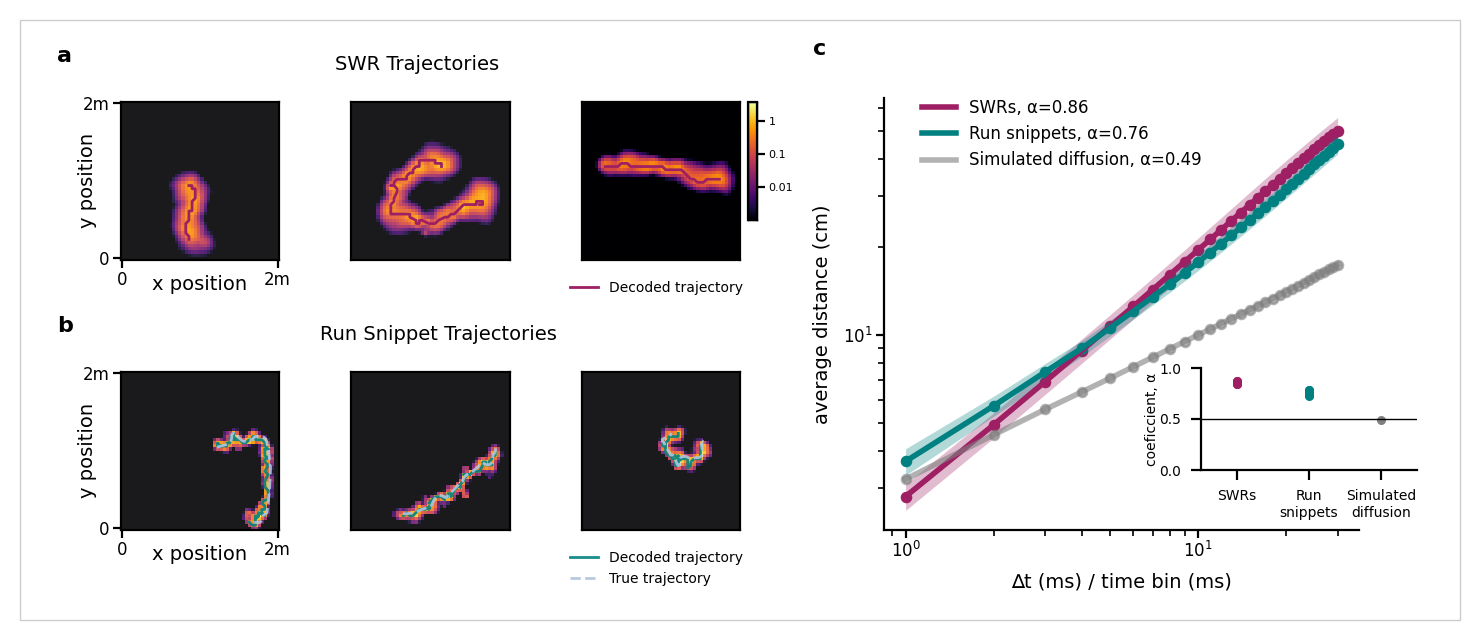

In [96]:
figure_width = 7.2
figure_height = 3

left_margin = 0.07
right_margin = 0.07
header_height = .05
footer_height = 0.15

viterbi_w_spacing = 0.05
w_spacing = 0.1

# define plot dimensions (relative to a "1x1" plot for a marginal)
viterbi_panel_width = .11
stella_panel_width = .4

fig = plt.figure(
    figsize=(figure_width, figure_height), dpi=200, facecolor="w", edgecolor="k"
)
ax = dict()

# add SWR viterbi panels
i = 0
panel_bottom = .6
panel_height = viterbi_panel_width * (figure_width/figure_height)
for j in range(3):
    panel_left = left_margin + viterbi_panel_width*j + viterbi_w_spacing*j
    ax[i,j] = fig.add_axes([panel_left, panel_bottom, viterbi_panel_width, panel_height])
    
    if j == 0:
        ax[i,j].set_xticks([0,49])
        ax[i,j].set_yticks([0,49])
        ax[i,j].set_xticklabels([0,'2m'])
        ax[i,j].set_yticklabels([0,'2m'])
        ax[i,j].set_xlabel('x position', fontsize=label_fontsize, labelpad=-5)
        ax[i,j].set_ylabel('y position', fontsize=label_fontsize, labelpad=-5)
        ax[i,j].tick_params(axis='both', labelsize=tick_fontsize, length=3, pad=1)
    else:
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

# add behavior viterbi panels
i = 1
panel_bottom = footer_height
panel_height = viterbi_panel_width * (figure_width/figure_height)
for j in range(3):
    panel_left = left_margin + viterbi_panel_width*j + viterbi_w_spacing*j
    ax[i,j] = fig.add_axes([panel_left, panel_bottom, viterbi_panel_width, panel_height])
    
    if j == 0:
        ax[i,j].set_xticks([0,49])
        ax[i,j].set_yticks([0,49])
        ax[i,j].set_xticklabels([0,'2m'])
        ax[i,j].set_yticklabels([0,'2m'])
        ax[i,j].set_xlabel('x position', fontsize=label_fontsize, labelpad=-5)
        ax[i,j].set_ylabel('y position', fontsize=label_fontsize, labelpad=-5)
        ax[i,j].tick_params(axis='both', labelsize=tick_fontsize, length=3, pad=1)
    else:
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

# add diffusion constant panels
panel_bottom = footer_height
panel_left = .6
panel_width = 1-right_margin - panel_left
panel_height = 1-footer_height - header_height - .08

ax[2] = fig.add_axes([panel_left, panel_bottom, panel_width, panel_height])

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].tick_params(axis='both', labelsize=tick_fontsize, length=3, pad=1)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('∆t (ms) / time bin (ms)', fontsize=label_fontsize)
ax[2].set_ylabel('average distance (cm)', fontsize=label_fontsize)


# -------------------------------------------
# add SWR viterbi data
for i, ripple in enumerate([17, 74, 79]):
    marg = get_marginal_sum(ripple_marginals[ripple])
    if i == 2:
            im = ax[0,i].imshow(marg, aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))
            
            axins1 = inset_axes(ax[0,i],
                    width="6%",  # width = 50% of parent_bbox width
                    height="75%",  # height : 5%
                    loc='lower right',
                    bbox_to_anchor=(0.11, .25, 1, 1),
                    bbox_transform=ax[0,i].transAxes,
                    borderpad=0)

            cbar = fig.colorbar(im, cax=axins1, orientation="vertical", ticks=np.log([.01, .1, 1]))
            cbar.ax.set_yticklabels(['0.01', '0.1', '1'])
            cbar.ax.tick_params(pad=1, length=3)
            
            axins1.set_frame_on(True)
            for axis in ['top','bottom','left','right']:
                axins1.spines[axis].set_linewidth(0.5)

            axins1.xaxis.set_ticks_position("top")
            axins1.yaxis.set_ticks_position("right")
            axins1.tick_params(labelsize=4)
    else:    
        ax[0,i].imshow(marg, aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4), alpha=.9)
    ax[0,i].plot(ripple_trajectories.most_likely_trajectories[ripple][:,1]/4, ripple_trajectories.most_likely_trajectories[ripple][:,0]/4,
            color=ripples_color, alpha=1, label='Decoded trajectory', linewidth=1)
    if i == 2:
        ax[0,i].legend(frameon=False, loc=4, fontsize=legend_fontsize, bbox_to_anchor=(1.1, -.3, 0, 0))

# add behavior viterbi data
for i, run_snippet in enumerate([2, 12, 33]): #27
    marg = get_marginal_sum(run_snippet_marginals[run_snippet])
    ax[1,i].imshow(marg, aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4), alpha=.9)
    ax[1,i].plot(run_snippet_trajectories.most_likely_trajectories[run_snippet][:,1]/4, run_snippet_trajectories.most_likely_trajectories[run_snippet][:,0]/4,
            color=behavior_color, alpha=.9, linewidth=1,label='Decoded trajectory', zorder=2)
    ax[1,i].plot(run_snippet_data.run_info["true_trajectories_cm"][run_snippet][:,1]/4, run_snippet_data.run_info["true_trajectories_cm"][run_snippet][:,0]/4,
        color='lightsteelblue', linestyle='dashed', alpha=.9, linewidth=1,label='True trajectory', zorder=3)
    
    if i == 2:
        ax[1,i].legend(frameon=False, loc=4, fontsize=legend_fontsize, bbox_to_anchor=(1.1, -.43, 0, 0))

        
# add diffusion constant data
trajectory_type = 'ripples_inferred'
distance_mean = np.mean(distance_by_time_mat[trajectory_type], axis=0)
distance_sd = np.std(distance_by_time_mat[trajectory_type], axis=0)
alpha_mean = np.mean(alpha_vec[trajectory_type])
plot_with_sd(ax[2], distance_mean, distance_sd, alpha_mean, trajectory_type, ripples_color, "SWRs")

trajectory_type = 'run_snippets_inferred'
distance_mean = np.mean(distance_by_time_mat[trajectory_type], axis=0)
distance_sd = np.std(distance_by_time_mat[trajectory_type], axis=0)
alpha_mean = np.mean(alpha_vec[trajectory_type])
plot_with_sd(ax[2], distance_mean, distance_sd, alpha_mean, trajectory_type, behavior_color, "Run snippets")


trajectory_type = 'simulated_diffusion'
distance_mean = results["simulated_diffusion"].diffusion_constant_info['distance_by_time']
alpha_mean = results["simulated_diffusion"].alpha
plot_without_sd(ax[2], distance_mean, alpha_mean, trajectory_type, "gray", "Simulated diffusion")

ax[2].legend(frameon=False, fontsize=6, loc=4, bbox_to_anchor=(.7,.8,0,0))

# -------------------------------------------

ax[0,1].text(-.1,1.2, "SWR Trajectories", size=7, transform=ax[0,1].transAxes)
ax[1,1].text(-.2,1.2, "Run Snippet Trajectories", size=7, transform=ax[1,1].transAxes)

ax[0,0].text(-.4,1.25, "a", size=8, transform=ax[0,0].transAxes, fontweight='bold')
ax[1,0].text(-.4,1.25, "b", size=8, transform=ax[1,0].transAxes, fontweight='bold')
ax[2].text(-.15,1.1, "c", size=8, transform=ax[2].transAxes, fontweight='bold')


ax[3] = fig.add_axes([1-.18, footer_height+.1, .15,.17])
inset_marker_size=5

for session in meta.Session_List:
    ripple_alpha_dist = results["ripples_inferred"][session.rat, session.day].bootstrap_alpha_dist
    ripple_mean = np.mean(ripple_alpha_dist)
    ripple_sd = np.std(ripple_alpha_dist)
    ax[3].scatter([0], ripple_mean, color=ripples_color, s=inset_marker_size)
    ax[3].errorbar([0], ripple_mean, yerr=ripple_sd, linewidth=0, color=ripples_color)
    
    run_snippet_alpha_dist = results["run_snippets_inferred"][session.rat, session.day].bootstrap_alpha_dist
    run_snippet_mean = np.mean(run_snippet_alpha_dist)
    run_snippet_sd = np.std(run_snippet_alpha_dist)
    ax[3].scatter([1], run_snippet_mean, color=behavior_color, s=inset_marker_size)
    ax[3].errorbar([1], run_snippet_mean, yerr=run_snippet_sd, linewidth=.75, color='teal')

sim_mean = np.mean(results["simulated_diffusion"].bootstrap_alpha_dist)
sim_sd = np.std(results["simulated_diffusion"].bootstrap_alpha_dist)
ax[3].scatter([2], sim_mean, color='gray', s=inset_marker_size)
ax[3].errorbar([2], sim_mean, yerr=sim_sd, linewidth=.75, color='gray')


ax[3].hlines(.5,-.5,2.5, linewidth=.5)

ax[3].set_xlim([-.5, 2.5])
ax[3].set_ylabel("coeficcient, α", fontsize=5, labelpad=0)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].set_yticks(np.linspace(0,1,3))
ax[3].set_xticks([0,1,2])
ax[3].set_xticklabels(['SWRs', 'Run\nsnippets', 'Simulated\ndiffusion'], rotation=0, ha='center')#, size=tick_fontsize)


plt.savefig(os.path.join(meta.FIGURES_PATH, "Figure5.svg"), dpi=500, transparent=True)


# visualize figure edge
rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0, 0), 1, 1, fill=False, color="k", lw=.5, alpha=.2,
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

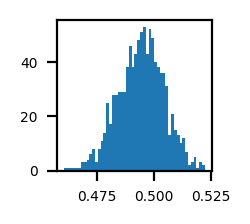

In [98]:
plt.figure(figsize=(1,1), dpi=200)
plt.hist(results["simulated_diffusion"].bootstrap_alpha_dist, bins=50)
plt.show()

In [101]:
(results["simulated_diffusion"].bootstrap_alpha_dist < .5).sum()/len(results["simulated_diffusion"].bootstrap_alpha_dist)

0.707

In [108]:
for session in meta.Session_List:
    print((results["run_snippets_inferred"][session.rat, session.day].bootstrap_alpha_dist > .5).sum()/len(results["run_snippets_inferred"][session.rat, session.day].bootstrap_alpha_dist > .5))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [109]:
for session in meta.Session_List:
    print((results["ripples_inferred"][session.rat, session.day].bootstrap_alpha_dist > .5).sum()/len(results["ripples_inferred"][session.rat, session.day].bootstrap_alpha_dist > .5))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
